##GPU Gacha!

In [ ]:
# If you want to reroll a new GPU, terminate current session and connect session again.
!/opt/bin/nvidia-smi

Wed Sep  8 09:57:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/My Drive/thesis/SiamNetOmnieyes'

Mounted at /content/drive


##Import libraries

In [ ]:
import os
import random
import torchvision
from torchvision import transforms
import torch
from torch.optim import lr_scheduler
# import torch.optim as optim
from torch.autograd import Variable
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import torch.nn as nn
import torch.nn.functional as F
import pickle
import json
import cv2
from copy import deepcopy

import zipfile
from io import BytesIO

!pip install torch-optimizer
import torch_optimizer as optim
from google.colab.patches import cv2_imshow
from IPython.display import display
from random import randrange

import math

import glob

from itertools import combinations

     |████████████████████████████████| 72 kB 803 kB/s 


##Signboard Dataset setup

In [ ]:
def pickle_save(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)
        
def pickle_load(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

In [ ]:
def read_obj_from_zip(unzipped_archive, data_path):
    '''
    read json or jpg from zip archive.
    
    returns: json or jpg; inputs other than json and jpg returns None.
    '''
    read_bytes = unzipped_archive.read(data_path)
    
    # check if data type is json or jpg and read the data respectively.
    if data_path.endswith('.json'):
        obj = json.loads(read_bytes.decode("utf-8"))
    elif data_path.endswith('.jpg'):
        data_encoded = BytesIO(read_bytes)
        try:
          img = cv2.imdecode(np.frombuffer(data_encoded.read(), np.uint8), 1) 
        except:
          img = None
        
        if img is not None:
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          img = Image.fromarray(img)
        obj = img  
    else:
        obj = None


    return obj

In [ ]:
def read_zip_data(root_path):   
    # read zip data:
    '''
      data format: zip_dict = {date:{zip: zip_archive, zip_dict: zip_path_dict}, date:{zip: zip_archive, zip_dict: zip_path_dict}....}
      date: date of driving record
      zip_archive: zip data
      zip_path_dict: a dict contains all the file paths of zip data. Each date contains videos data separately.

      {
        '20200404:   {
                        zip: (zipfile archive)
                        zip_dict:   {
                                      '108-7B_01_20200404_073500':   {imgs: [A list of image paths refers to 108-7B_01_20200404_073500], json: JSON file of 108-7B_01_20200404_073500}
                                      ....
                                      ....
                                    }
                      },

        '20200405:   {
                        zip: (zipfile archive)
                        zip_dict:   {
                                      ...
                                      ... 
                                    }
                     },
        ...
        ...
      }

    '''
    zip_dir_list = glob.glob(root_path + '/*.zip')

    zip_dict = {}
    all_vid_path_list = []
    for zip_dir in zip_dir_list:
        zip_date = zip_dir.split('/')[-1].split('.')[0]

        print(f"Processing {zip_dir}...")
        z = zipfile.ZipFile(zip_dir, 'r')
        z_namelist = z.namelist()

        zip_path_dict = {}
        for obj_path in z_namelist:
            vid_path = obj_path.split('/')[1]
            # remove duplicate paths
            if '(1)' in obj_path:
                continue
            # save image data.
            else:       
                if obj_path.endswith('.jpg'):                              
                    if vid_path not in zip_path_dict.keys():
                        zip_path_dict[vid_path] = {'imgs':[obj_path], 'json':None}
                    else:
                        zip_path_dict[vid_path]['imgs'].append(obj_path)
                        
                elif obj_path.endswith('.json'):
                    if vid_path not in zip_path_dict.keys():
                        zip_path_dict[vid_path] = {'imgs':[], 'json':obj_path}
                    else:
                        zip_path_dict[vid_path]['json'] = obj_path

        zip_dict[zip_date] = {'zip': z, 'zip_dict': zip_path_dict}


    return zip_dict

In [ ]:
def read_group_paths(signboard_obj, max_length=-1):
    group_paths = []
    
    # max_length = -1 to read all frame_id images
    if max_length == -1:
        read_frame_id = signboard_obj.frame_id
    elif max_length == 0:
        print('Max length has set to 0. No images will be loaded.')
        return group_paths
    else:
        # handle frame_id length < max_length situations.
        k_value = min(len(signboard_obj.frame_id), max_length)
        read_frame_id = random.sample(signboard_obj.frame_id, k=k_value)


    input_signboard_trk_id = signboard_obj.trk_id
    
    # handling extended signboard track ids
    signboard_trk_id = input_signboard_trk_id.split('_')[0] if '_'in input_signboard_trk_id else input_signboard_trk_id

    for frame in signboard_obj.frame_id:           
        frame_file_name = f'track_{signboard_trk_id}_{frame}.jpg'
        trk_date, trk_vid_name = signboard_obj.date, signboard_obj.vid_name

        file_path = os.path.join(trk_date, trk_vid_name, 'tracks', frame_file_name)

        group_paths.append(file_path)

    return group_paths

In [ ]:
def form_dataset(filtered_result_paths, addBlurred=False, max_length=100):
    all_datasets = []
    label = 0
    for path in filtered_result_paths:
        dataset = []
        filter_results = pickle_load(path)[1]
        print('Group length:', len(filter_results))
        # group_elem_num = 0
        for filtered_sign_obj_group in filter_results:
            data_group = read_group_paths(filtered_sign_obj_group['query'])
            confirmed_group = [read_group_paths(sign_obj) for sign_obj in filtered_sign_obj_group['confirmed']]
            for group in confirmed_group:
                data_group += group

            if addBlurred:
                blurred_group = [read_group_paths(sign_obj) for sign_obj in filtered_sign_obj_group['blurred']]

                for group in blurred_group:
                    data_group += group
            
            # data balancing:
            if len(data_group) > max_length:
                # calculate sample data's balanced interval.
                data_sample_interval = int(len(data_group) / max_length)
                # when data_group is not enough to have a balance interval(interval = 1), random sample data.
                if data_sample_interval == 1:
                    data_group = random.sample(data_group, k=max_length)
                else:
                    data_group = [data_group[i * data_sample_interval] for i in range(max_length)]

            # labeling
            data_group = [[data, label] for data in data_group]

            dataset.append(data_group)
            label += 1
        all_datasets.append(dataset)
        
    return all_datasets

In [ ]:
 # A class that stored a tracked signboard information
class SignBoard(object):
    def __init__(self, trk_record_info, trk_id, date, vid_name):# , trk_path):
        # self.trk_data_path = trk_path
        self.frame_id = trk_record_info['frame_id']

        self.gps_list = [[math.radians(trk_gps[1]), math.radians(trk_gps[0])] for trk_gps in trk_record_info['gps']]

        self.gps_median = statistics.median_low(self.gps_list)

        self.trk_id = trk_id

        self.date = date

        self.vid_name = vid_name
    

####read tracked data

In [ ]:
### relocate this path to your corresponding drive path;
trk_info_root_path = '/content/drive/MyDrive/thesis/OmnieyesDataset/tmp2/tracking_results'

### and also relocate team members folder path.
team_folder_path = '/content/drive/My Drive/To_team_members'

car_name = '108-7B'
car_trk_info_root_path = os.path.join(trk_info_root_path, car_name)

zip_dict = read_zip_data(car_trk_info_root_path)

Processing /content/drive/MyDrive/thesis/OmnieyesDataset/tmp2/tracking_results/108-7B/20200404.zip...
Processing /content/drive/MyDrive/thesis/OmnieyesDataset/tmp2/tracking_results/108-7B/20200418.zip...
Processing /content/drive/MyDrive/thesis/OmnieyesDataset/tmp2/tracking_results/108-7B/20200413.zip...
Processing /content/drive/MyDrive/thesis/OmnieyesDataset/tmp2/tracking_results/108-7B/20200416.zip...
Processing /content/drive/MyDrive/thesis/OmnieyesDataset/tmp2/tracking_results/108-7B/20200414.zip...
Processing /content/drive/MyDrive/thesis/OmnieyesDataset/tmp2/tracking_results/108-7B/20200428.zip...
Processing /content/drive/MyDrive/thesis/OmnieyesDataset/tmp2/tracking_results/108-7B/20200417.zip...
Processing /content/drive/MyDrive/thesis/OmnieyesDataset/tmp2/tracking_results/108-7B/20200405.zip...
Processing /content/drive/MyDrive/thesis/OmnieyesDataset/tmp2/tracking_results/108-7B/20200422.zip...
Processing /content/drive/MyDrive/thesis/OmnieyesDataset/tmp2/tracking_results/108

####read filtered data and form dataset

In [ ]:
filtered_data_path = '/content/drive/MyDrive/To_team_members/2021_05_12_Tracking_data_filtering/trk_filter_results/checkpoints'

all_members_paths = glob.glob(os.path.join(filtered_data_path, '*'))

all_members_latest_paths = []

for member_path in all_members_paths:
    list_of_files = glob.glob(os.path.join(member_path, '*.pickle'))
    latest_file = max(list_of_files, key=os.path.getctime)
    all_members_latest_paths.append(latest_file)
    print(latest_file)

/content/drive/MyDrive/To_team_members/2021_05_12_Tracking_data_filtering/trk_filter_results/checkpoints/Vitor/group_5_checkpoint_611.pickle
/content/drive/MyDrive/To_team_members/2021_05_12_Tracking_data_filtering/trk_filter_results/checkpoints/Sebastian/group_4_checkpoint_109.pickle
/content/drive/MyDrive/To_team_members/2021_05_12_Tracking_data_filtering/trk_filter_results/checkpoints/James/group_1_checkpoint_600.pickle
/content/drive/MyDrive/To_team_members/2021_05_12_Tracking_data_filtering/trk_filter_results/checkpoints/Jasper/group_6_checkpoint_475.pickle
/content/drive/MyDrive/To_team_members/2021_05_12_Tracking_data_filtering/trk_filter_results/checkpoints/Darren/group_0_checkpoint_164.pickle


In [ ]:
labeled_dataset = form_dataset(all_members_latest_paths, max_length=40)

Group length: 611
Group length: 109
Group length: 600
Group length: 475
Group length: 164


Total signboards in training dataset: 32459


##Signboard dataset


In [ ]:
rand_crop_ratio = 0.8

def random_crop(pil_img):
    width, height = pil_img.size
    target_width = width * rand_crop_ratio
    target_height = height * rand_crop_ratio
    x_max = width - target_width
    y_max = height - target_height

    random_x = randrange(0, x_max//2 + 1) * 2
    random_y = randrange(0, y_max//2 + 1) * 2

    area = (random_x, random_y, random_x + target_width, random_y + target_height)
    result = pil_img.crop(area)

    return result

In [ ]:
def expand2square(pil_img):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), (0, 0, 0))
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), (0, 0, 0))
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

####Data augmentations

In [ ]:
prob = .5

brightness = (.5, 3)
contrast = (.5, 3)
saturation = (.5, 2)
hue = (0.0, 0.05)


aug_transforms = transforms.Compose([               
                transforms.RandomApply([
                    transforms.Lambda(random_crop),
                    # transforms.RandomHorizontalFlip(p=1.0),                 
                    transforms.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue),
                    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 1.0))
                    ], p=prob),
                transforms.RandomPerspective(distortion_scale=0.5,p=prob, fill=(0,0,0)),
                # transforms.Lambda(expand2square),
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])


####Dataset class

In [ ]:
class TripletSignboard_v2():
    def __init__(self, zip_dict=None, dataset=[], batch_size=64, transforms=None, isTrain=True, pos_num=2, dataset_lower_bound=0):
        self.zip_dict = zip_dict
        self.transforms = transforms
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffled_dataset = []
        self.isTrain = isTrain
        self.pos_num = pos_num
        self.dataset_lower_bound = dataset_lower_bound

        if dataset_lower_bound:
            del_list = []
            for idx, data in enumerate(self.dataset):
                if len(data) < dataset_lower_bound:
                      del_list.append(idx)
            
            for idx in reversed(del_list):
                  self.dataset.pop(idx)
                


    def data_shuffle(self):
        shuffle_data = deepcopy(self.dataset)
        random.shuffle(shuffle_data)
        # shuffle_sequences = random.sample(range(len(shuffle_data)), k=len(shuffle_data))
        full_batches = []
        while shuffle_data:
            filtered_group_set = shuffle_data.pop(0)
            while True:
                total_filtered_elem = sum([len(data) for data in filtered_group_set])
                # if filtered group set's elements cannot fill a batch, then stop shuffling on this group set.
                if total_filtered_elem < self.batch_size:
                    break
                
                
                # pick a group randomly.
                rand_group_choice = random.choice(range(len(filtered_group_set)))
                # if the group has less than 2 elements (cannot form a positive pair), then find another group.
                if len(filtered_group_set[rand_group_choice]) < self.pos_num:
                    continue
                    
                # pick 2 elements to confirm existing a positive pair in the batch.
                rand_elem_choices = sorted(random.sample(range(len(filtered_group_set[rand_group_choice])), k=self.pos_num), reverse=True)
                batch = [filtered_group_set[rand_group_choice].pop(choice) for choice in rand_elem_choices]

                batch_cnt = self.batch_size - self.pos_num

                while batch_cnt > 0:                   
                    batch_rand_group_choice = random.choice(range(len(filtered_group_set)))
                    # skip if the group has no elements.
                    if len(filtered_group_set[batch_rand_group_choice]) < 1:
                        continue
                    # pick an random element from random group.
                    batch_rand_elem_choice = random.choice(range(len(filtered_group_set[batch_rand_group_choice])))
                    batch.append(filtered_group_set[batch_rand_group_choice].pop(batch_rand_elem_choice))


                    batch_cnt -= 1
                
                # batch label check (at least 2 different labels to form negative pairs.)
                isSameLabel = True

                batch_current_label = batch[0][1]
                for batch_data in batch:
                      if batch_data[1] != batch_current_label:
                          isSameLabel = False
                
                if isSameLabel:
                    continue
                else:
                    if self.isTrain:
                        random.shuffle(batch)
                    full_batches += batch

        self.shuffled_dataset = full_batches

      
    def __getitem__(self,index):     
        data = self.shuffled_dataset[index]

        # set label
        label = data[1]
        
        # read query image
        img_path = data[0]     
        img_date = img_path.split('/')[0]

        img = read_obj_from_zip(self.zip_dict[img_date]['zip'], img_path)

        # Apply image transformations
        if self.transforms is not None:
            trans_img = self.transforms(img)
        else:
            trans_img = img

        return trans_img , label

    
    def __len__(self):
        return len(self.shuffled_dataset)

###test Triplet dataset

In [ ]:
test_dataset = TripletSignboard_v2(zip_dict=zip_dict, dataset=labeled_dataset, batch_size=64, transforms=None)

In [ ]:
test_dataset.data_shuffle()

In [ ]:
print(len(test_dataset))

61248


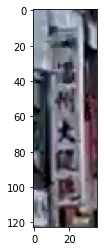

Label: 761
-------------------------------------------------------------------------


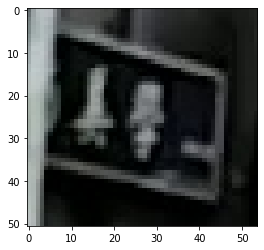

Label: 835
-------------------------------------------------------------------------


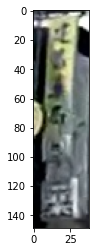

Label: 822
-------------------------------------------------------------------------


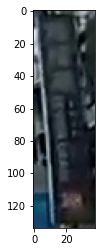

Label: 973
-------------------------------------------------------------------------


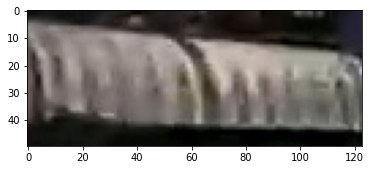

Label: 1187
-------------------------------------------------------------------------


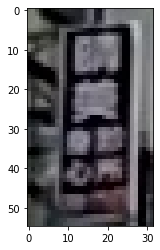

Label: 834
-------------------------------------------------------------------------


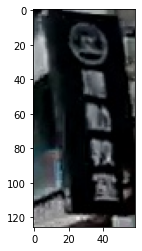

Label: 1151
-------------------------------------------------------------------------


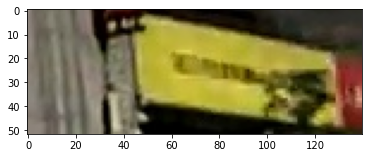

Label: 1120
-------------------------------------------------------------------------


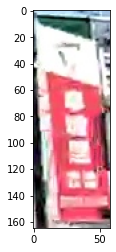

Label: 884
-------------------------------------------------------------------------


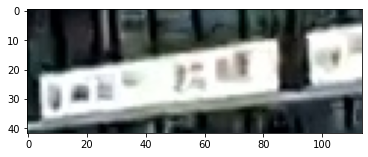

Label: 783
-------------------------------------------------------------------------


In [ ]:
for i in range(10):
    img, label = test_dataset[i]
    plt.imshow(img)
    plt.show()
    print('Label:', label)
    print('-------------------------------------------------------------------------')

##EmbeddingNet

In [ ]:
class EmbeddingResnet(nn.Module):
    def __init__(self, fixed_blocks=0):
        super(EmbeddingResnet, self).__init__()

        resnet = torchvision.models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])

        # Fix blocks
        for p in self.features[0].parameters():
            p.requires_grad = False
        for p in self.features[1].parameters():
            p.requires_grad = False
        if fixed_blocks >= 3:
            for p in self.features[6].parameters():
                p.requires_grad = False
        if fixed_blocks >= 2:
            for p in self.features[5].parameters():
                p.requires_grad = False
        if fixed_blocks >= 1:
            for p in self.features[4].parameters():
                p.requires_grad = False

        def set_bn_fix(m):
            classname = m.__class__.__name__
            if classname.find('BatchNorm') != -1:
                for p in m.parameters(): p.requires_grad = False

        self.features.apply(set_bn_fix)

    def forward(self, x):
        features = self.features.forward(x)

        features = features.view(features.size(0), -1)
        # features = F.normalize(features, p=2, dim=1)
        return features

##trainer

In [ ]:
def fit(train_dataset, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, batch_size, metrics=[],
        start_epoch=0, history=None, model_folder_name=None, model_name=None):

    if start_epoch != 0:
        print("Training start from {} epoch:".format(start_epoch))
    
    if scheduler != None:
        for epoch in range(0, start_epoch):
            scheduler.step()

    print("---Training begins!---")
    for epoch in range(start_epoch, start_epoch + n_epochs):
        print('Epoch:', epoch)
        print('-----------------------')
        if scheduler != None:
            scheduler.step()

        total_train_epoch_loss = 0

        ########## TRAINING ##########
        train_dataset.data_shuffle()

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, **kwargs)

        train_loss = train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics, batch_size)


        history['train'].append(train_loss)

        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)


        save_dir = drive_path + "/models/" + model_folder_name

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        
        torch.save(embedding_net.state_dict(), (save_dir + model_name + str(epoch)  + ".pt"))

        hist_save_dir = drive_path + '/history/' + model_folder_name

        if not os.path.exists(hist_save_dir):
            os.makedirs(hist_save_dir)

        with open( (hist_save_dir + model_name + str(epoch) +".txt" ) , 'wb') as hist_write:
                pickle.dump(history, hist_write)

        print("Model from epoch {} has been saved successfully.".format(str(epoch)) )



##train_epoch

In [ ]:
class OnlineTripletLoss(nn.Module):
    """
    Online Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(OnlineTripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):
        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()

        # ###### L2 norm ######
        ap_distances = (embeddings[triplets[:, 0]] - embeddings[triplets[:, 1]]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[triplets[:, 0]] - embeddings[triplets[:, 2]]).pow(2).sum(1)  # .pow(.5)
        ###### cosine similarity ######
        # ap_distances = 1.0 - F.cosine_similarity(embeddings[triplets[:, 0]], embeddings[triplets[:, 1]], dim=1, eps=1e-10)
        # an_distances = 1.0 - F.cosine_similarity(embeddings[triplets[:, 0]], embeddings[triplets[:, 2]], dim=1, eps=1e-10)

        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean(), len(triplets)

In [ ]:
# ########## Calculate element-wise Euclidean distance ############
def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix

In [ ]:
# ########## Calculate element-wise cosine similarity ############
# def cos_sim(vectors):
#     distance_matrix = F.cosine_similarity(vectors.unsqueeze(1), vectors.unsqueeze(0), dim=2, eps=1e-10)

#     return distance_matrix

In [ ]:
class TripletSelector:
    """
    Implementation should return indices of anchors, positive and negative samples
    return np array of shape [N_triplets x 3]
    """

    def __init__(self):
        pass

    def get_triplets(self, embeddings, labels):
        raise NotImplementedError


class AllTripletSelector(TripletSelector):
    """
    Returns all possible triplets
    May be impractical in most cases
    """

    def __init__(self):
        super(AllTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # Add all negatives for all positive pairs
            temp_triplets = [[anchor_positive[0], anchor_positive[1], neg_ind] for anchor_positive in anchor_positives
                             for neg_ind in negative_indices]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))


def hardest_negative(loss_values):
    hard_negative = np.argmax(loss_values)
    return hard_negative if loss_values[hard_negative] > 0 else None


def random_hard_negative(loss_values):
    hard_negatives = np.where(loss_values > 0)[0]
    return np.random.choice(hard_negatives) if len(hard_negatives) > 0 else None


def semihard_negative(loss_values, margin):
    semihard_negatives = np.where(np.logical_and(loss_values < margin, loss_values > 0))[0]
    return np.random.choice(semihard_negatives) if len(semihard_negatives) > 0 else None


class FunctionNegativeTripletSelector(TripletSelector):
    """
    For each positive pair, takes the hardest negative sample (with the greatest triplet loss value) to create a triplet
    Margin should match the margin used in triplet loss.
    negative_selection_fn should take array of loss_values for a given anchor-positive pair and all negative samples
    and return a negative index for that pair
    """

    def __init__(self, margin, negative_selection_fn, cpu=True):
        super(FunctionNegativeTripletSelector, self).__init__()
        self.cpu = cpu
        self.margin = margin
        self.negative_selection_fn = negative_selection_fn

    def get_triplets(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        # distance_matrix = 1.0 - cos_sim(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)

            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()
                hard_negative = self.negative_selection_fn(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)

        return torch.LongTensor(triplets)


def HardestNegativeTripletSelector(margin, cpu=False): return FunctionNegativeTripletSelector(margin=margin,
                                                                                 negative_selection_fn=hardest_negative,
                                                                                 cpu=cpu)


def RandomNegativeTripletSelector(margin, cpu=False): return FunctionNegativeTripletSelector(margin=margin,
                                                                                negative_selection_fn=random_hard_negative,
                                                                                cpu=cpu)


def SemihardNegativeTripletSelector(margin, cpu=False): return FunctionNegativeTripletSelector(margin=margin,
                                                                                  negative_selection_fn=lambda x: semihard_negative(x, margin),
                                                                                  cpu=cpu)

In [ ]:
def train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics, batch_size):

    for metric in metrics:
        metric.reset()

    model.train()
    losses = []


    for batch_idx, (data, target) in enumerate(train_loader):
        
        if cuda:
            imgs = data.cuda()
            if target is not None:
                target = target.cuda()

        optimizer.zero_grad()

        outputs = model(imgs)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target
        
        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        loss.backward()
        optimizer.step()


        if batch_idx % log_interval == 0 and batch_idx != 0:
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx, len(train_loader),
                100. * batch_idx / len(train_loader), np.mean(losses))


            print(message)


    return np.mean(losses)

##Training setup

##basic setup

In [ ]:
cuda = torch.cuda.is_available()

batch_size = 128

# if you want to use scheduler, please turn it on and set milestones numbers you want.
useScheduler = True
milestones_num = 2

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set up the network and training parameters
model_folder_name = 'comparison/Triplet/Tracked_filtered_data/Track_filtered_data_Triplet_mar_4.0/'
embedded_model_name = 'Track_filtered_data_Triplet_mar_4.0_epoch_'

start_epoch = 0

margin = 4.0
embedding_net = EmbeddingResnet(fixed_blocks=2)

if cuda:
    embedding_net.cuda()

loss_fn = OnlineTripletLoss(margin, SemihardNegativeTripletSelector(margin))

lr = 1e-3
optimizer = optim.RAdam(embedding_net.parameters(), lr=lr)

n_epochs = 300

# added scheduler
if useScheduler:
    milestones_interval = int(n_epochs / (milestones_num + 1) )

    m_interval_list = [i * milestones_interval for i in range(1, milestones_num + 1)]
    print('milestones_interval:', m_interval_list)

    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=m_interval_list, gamma=0.5)
else:
    scheduler = None

log_interval = 20

history_log = {'train':[], 'val':[]}

milestones_interval: [100, 200]


In [ ]:
model_folder_name = 'comparison/Triplet/Track_filtered_data_Triplet_mar_2.0/'
embedded_model_name = 'Track_filtered_data_Triplet_mar_2.0_epoch_'




cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

start_epoch = 100
load_epoch = start_epoch - 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
history_log = {'train':[], 'val':[]}
with open( (drive_path + '/history/' + model_folder_name + embedded_model_name + str(load_epoch) +".txt" ) , 'rb') as hist_read:
        history_log = pickle.load(hist_read)
        
embedding_net = EmbeddingResnet(fixed_blocks=2).cuda()
embedding_net.load_state_dict(torch.load(drive_path + "/models/" + model_folder_name + embedded_model_name + str(load_epoch) + ".pt"))


<All keys matched successfully>

##form dataset

###split test dataset

In [ ]:
temp_dataset = deepcopy(labeled_dataset)
test_labeled_dataset = [temp_dataset.pop(4)]

# ### using original training datset shape on training.
train_labeled_dataset = temp_dataset

### combine all GPS groups of training dataset
# train_labeled_dataset = []
# for dataset in temp_dataset:
#     train_labeled_dataset += dataset

# train_labeled_dataset = [train_labeled_dataset]

In [ ]:
for test in temp_dataset:
    print(len(test))

611
109
600
475


In [ ]:
train_dataset = TripletSignboard_v2(zip_dict=zip_dict, dataset=train_labeled_dataset, batch_size=batch_size,
                                 transforms=aug_transforms
                                )

###train model

In [ ]:
fit(train_dataset, embedding_net, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, batch_size, start_epoch=start_epoch,
    history=history_log, model_folder_name=model_folder_name, model_name=embedded_model_name)

---Training begins!---
Epoch: 0
-----------------------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [20/253 (8%)]	Loss: 1.970888
Train: [40/253 (16%)]	Loss: 2.022018
Train: [60/253 (24%)]	Loss: 2.007903
Train: [80/253 (32%)]	Loss: 1.987171
Train: [100/253 (40%)]	Loss: 2.020006
Train: [120/253 (47%)]	Loss: 2.011286
Train: [140/253 (55%)]	Loss: 2.000563
Train: [160/253 (63%)]	Loss: 1.999685
Train: [180/253 (71%)]	Loss: 1.988270
Train: [200/253 (79%)]	Loss: 1.999976
Train: [220/253 (87%)]	Loss: 1.988892
Train: [240/253 (95%)]	Loss: 1.985600
Model from epoch 0 has been saved successfully.
Epoch: 1
-----------------------
Train: [20/253 (8%)]	Loss: 1.858258
Train: [40/253 (16%)]	Loss: 1.884531
Train: [60/253 (24%)]	Loss: 1.899650
Train: [80/253 (32%)]	Loss: 1.920370
Train: [100/253 (40%)]	Loss: 2.000352
Train: [120/253 (47%)]	Loss: 1.986170
Train: [140/253 (55%)]	Loss: 1.992887
Train: [160/253 (63%)]	Loss: 1.991661
Train: [180/253 (71%)]	Loss: 1.994398
Train: [200/253 (79%)]	Loss: 1.994473
Train: [220/253 (87%)]	Loss: 2.001961
Train: [240/253 (95%)]	Loss: 2.000439
Model from epoch 